In [8]:
# %pip install pydotplus
# %pip install --upgrade pip
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
from pydotplus import graph_from_dot_data

import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

data = pd.read_csv("hotel_bookings.csv")
data.head()

data = data.dropna(subset=["children"])
data["is_canceled"].value_counts()

is_canceled
0    75166
1    44220
Name: count, dtype: int64

Data si na testovací a trénovací sadu rozdělíme ručně, protože nevyužíváme GridSearchCV

In [9]:
X = data[["lead_time"]]
y = data["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Dále vytvoříme DecisionTreeClassifier, což je klasifikátor využívající algoritmus rozhodovacího stromu. Necháme nastavené výchozí parametry.
max_depth = hloubka stromu ("počet pater" stromu)

In [10]:
clf = DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Dále vygenerujeme grafický výstup. Využijeme funkci export_graphviz
- oproti lekci přidávám pouze class names

Note: you may need to restart the kernel to use updated packages.


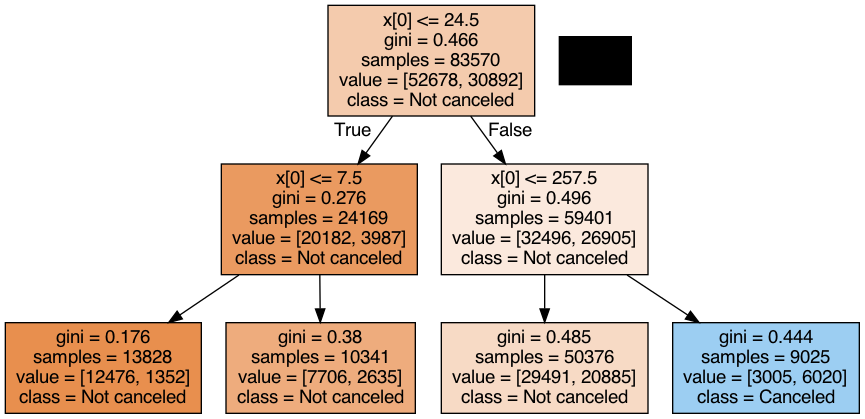

In [11]:
%pip install pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, class_names=["Not canceled", "Canceled"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Kvalitu predikcí takto gigantického stromu můžeme ověřit pomocí matice záměn, která má stejnou strukturu a stejnou interpretaci jako v předchozích lekcí.

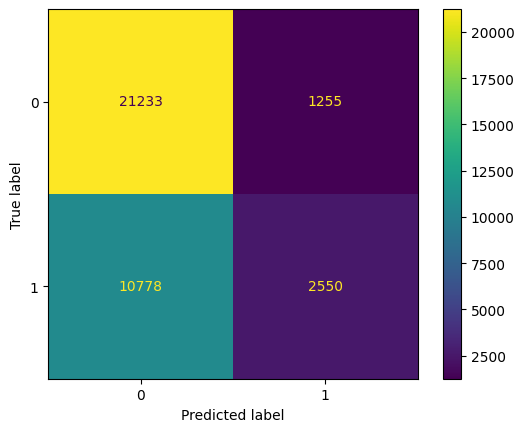

In [12]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

Též můžeme spočítat všechny metriky, které jsme si již ukázali.

In [13]:
accuracy_score(y_test, y_pred)

0.6640328344873799

In [14]:
balanced_accuracy_score(y_test, y_pred)

0.5677594944060869

Na tento údaj nepotřebujeme použít OneHotEncoder(). Proto vytvoříme dva seznamy sloupců:

categorical_columns, kam uložíme sloupce s kategorickými hodnotami,
numeric_columns, kam uložíme sloupce (resp. sloupec) s numerickými hodnotami.

In [15]:
categorical_columns = ["country", "market_segment", "distribution_channel", "arrival_date_month", "meal"]
numeric_columns = ["lead_time", "stays_in_weekend_nights", "stays_in_week_nights", "adults", "children", "babies", "is_repeated_guest", "previous_cancellations", "previous_bookings_not_canceled"]

In [16]:
data[numeric_columns].head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled
0,342,0,0,2,0.0,0,0,0,0
1,737,0,0,2,0.0,0,0,0,0
2,7,0,1,1,0.0,0,0,0,0
3,13,0,1,1,0.0,0,0,0,0
4,14,0,2,2,0.0,0,0,0,0


Z tabulky data vybereme sloupce v seznamu others a převedeme je na pole s využitím metody to_numpy(). Následně sloupce v seznamu categorical_columns upravíme pomocí OneHotEncoder. Nakonec obě pole spojíme do jednoho pomocí funkce numpy.concatenate(). Tato funkce je jakousi "hloupější" verzí funkce merge(), kterou známe z pandas. Spojuje dvě matice do jedné na základě čísla řádků, tj. vezme nultý řádek z obou polí a vytvoří z něj jeden dlouhý řádek v nové matici, to samé s prvním řádkem atd.

In [17]:
others = data[numeric_columns].to_numpy()
ohe = OneHotEncoder()
encoded_columns = ohe.fit_transform(data[categorical_columns])
encoded_columns = encoded_columns.toarray()
X = np.concatenate([encoded_columns, others], axis=1)

Na konci data opět rozdělíme na trénovací a testovací.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Hledání nejlepší parametrů
Ke hledání nejlepší parametrů opět využijeme GridSearchCV

In [19]:
model = DecisionTreeClassifier()
params = {"min_samples_split": [10, 20, 30, 40]}

clf = GridSearchCV(model, params, scoring="accuracy")
clf.fit(X, y)

print(clf.best_params_)
print(clf.best_score_)

{'min_samples_split': 40}
0.6447402887589049


In [20]:
model = DecisionTreeClassifier()
params = {"min_samples_split": [10, 20, 30, 40]}

clf = GridSearchCV(model, params, scoring="accuracy")
clf.fit(X, y)

print(clf.best_params_)
print(clf.best_score_)

{'min_samples_split': 40}
0.6446062787451435
